In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.io import loadmat

from src.utils import get_cc_mat, get_dataset

### Get data

In [18]:
df = get_dataset(
    labels_file="./data/class_vector_train_ref.mat", 
    params_file="./data/training_set_ref.mat",
    names_file="./data/paremeterNames.mat"
)

print(f'***Dataset shape: {df.shape}')

# Value counts of the stability label
print('***Value counts of the stability label:')
print(df['label'].value_counts(normalize=True).round(4))

df.head()

***Dataset shape: (200000, 259)
***Value counts of the stability label:
0    0.5287
1    0.4713
Name: label, dtype: float64


,BIO@atp_c,BIO@pyr_c,BIO@nad_c,BIO@g6p_c,BIO@oaa_c,BIO@f6p_c,BIO@nadph_c,BIO@nh4_c,BIO@o2_c,BIO@r5p_c,...,D_LAC@feri_m,D_LAC@lac_m,SUCCt2r@suc_c,MALt2r@mal_c,CITt2m@mal_c,CITt2m@cit_m,CITt2m@mal_m,CITt2m@cit_c,PFK@amp_c,label
0,0.457634,0.014440,0.058212,0.676883,0.341359,0.662601,0.558494,0.469465,0.379688,0.031882,...,0.310612,0.176318,0.750574,0.835077,0.636952,0.805681,0.314653,0.601644,0.442062,1
1,0.011809,0.879388,0.003459,0.746891,0.306732,0.324433,0.790872,0.561433,0.601143,0.729455,...,0.260641,0.480122,0.828887,0.774984,0.793254,0.111233,0.174306,0.035144,0.432545,1
2,0.150170,0.442691,0.029388,0.930178,0.904467,0.690296,0.083225,0.292097,0.122153,0.097039,...,0.780362,0.548510,0.591525,0.579699,0.168482,0.214867,0.430102,0.757192,0.281138,1
3,0.241337,0.108236,0.874900,0.908554,0.945598,0.204189,0.396873,0.474224,0.738103,0.958655,...,0.998683,0.015408,0.362024,0.127115,0.230577,0.996991,0.195371,0.013773,0.316083,1
4,0.357361,0.179095,0.737178,0.371373,0.562450,0.809965,0.920162,0.750900,0.623332,0.356794,...,0.298213,0.555471,0.611591,0.020826,0.543747,0.459455,0.110901,0.838803,0.561902,1


### Feature Selection

In [20]:
from mrmr import mrmr_classif

K = int(df.drop('label', axis=1).shape[1] / 4)
print(f'***Number of features to select: {K}')
selected_features = mrmr_classif(X=df.drop('label', axis=1), y=df['label'], K=K)

***Number of features to select: 64


100%|██████████| 64/64 [01:00<00:00,  1.06it/s]


### FFC

In [21]:
enzyme, commonEnz, allEnzymes, \
    commonConCoeff, allConCoeff = get_cc_mat('./data/ccXTR_ref.mat')


Enzyme: XTR
Common enzymes: ['HXK', 'PGI', 'TPI', 'ZWF', 'ATPM', 'ADK', 'NDR', 'PDA', 'XTR', 'XRI', 'XDH', 'XK']
Number of all enzymes: 86


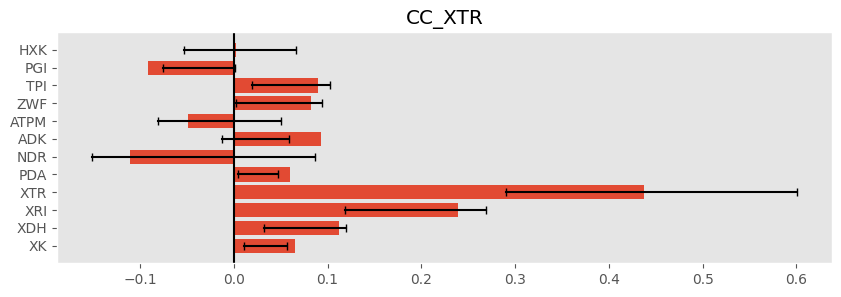

In [22]:
# Change plot style
plt.style.use('ggplot')

# Calculate the 1st and 3rd quartiles of commonConCoeff values
q1 = commonConCoeff.quantile(0.25)
q3 = commonConCoeff.quantile(0.75)

# Plot the mean of commonConCoeff values
plt.figure(figsize=(10, 3))
plt.barh(commonConCoeff.columns[::-1], commonConCoeff.mean()[::-1])
plt.axvline(x=0, color='black', linestyle='-')
plt.plot(q1, commonConCoeff.columns, '|', color='black', label='Q1', alpha=1)
plt.plot(q3, commonConCoeff.columns, '|', color='black', label='Q3', alpha=1)
for i, enzyme in enumerate(commonConCoeff.columns):
    plt.plot([q1[i], q3[i]], [enzyme, enzyme], color='black')
plt.title("CC_XTR")
plt.grid()
plt.show()

### Dataset formulation

In [23]:
idx_HXK = commonConCoeff[commonConCoeff['HXK'] < 0].index
df_HXK = df.drop('label', axis=1)
df_HXK['label'] = [1 if i in idx_HXK else 0 for i in df_HXK.index]
df_HXK['label'].value_counts(normalize=True).round(4)

0    0.5287
1    0.4713
Name: label, dtype: float64

In [24]:
# # Keep only the features selected by mRMR
# df_HXK = df_HXK[selected_features + ['label']]
# print(f'***Dataset shape: {df_HXK.shape}')

***Dataset shape: (200000, 65)


In [14]:
from src.machinelearning import train_xgboost, evaluate_sklean
from sklearn.model_selection import train_test_split

X = df_HXK.drop('label', axis=1)
y = df_HXK['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.99, random_state=42)

print(f'Traininig set shape: {X_train.shape}')
print(f'Test set shape: {X_test.shape}')

xgb_model = train_xgboost(X_train, y_train, n_trials=100)

[I 2024-09-29 15:11:51,455] A new study created in memory with name: no-name-94ac715f-d6c9-4c6f-97e2-e6c108e11cdb


Traininig set shape: (2000, 258)
Test set shape: (198000, 258)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.276) total time=  28.9s
[CV] END ................................ score: (test=0.233) total time=  29.0s
[CV] END ................................ score: (test=0.165) total time=  29.1s


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   29.7s finished
[I 2024-09-29 15:12:21,244] Trial 0 finished with value: 0.22453599531110394 and parameters: {'learning_rate': 0.1049021285336682, 'n_estimators': 127, 'max_depth': 10, 'subsample': 0.6450760877729136, 'booster': 'dart', 'tree_method': 'hist', 'reg_alpha': 0.3698414726113932, 'reg_lambda': 0.8143838205916376}. Best is trial 0 with value: 0.22453599531110394.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.272) total time=  10.8s
[CV] END ................................ score: (test=0.229) total time=  10.9s


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.7s finished
[I 2024-09-29 15:12:33,080] Trial 1 finished with value: 0.2562013545195469 and parameters: {'learning_rate': 0.0641324185462614, 'n_estimators': 243, 'max_depth': 9, 'subsample': 0.7996022598923374, 'booster': 'gbtree', 'tree_method': 'hist', 'reg_alpha': 0.2752392437394473, 'reg_lambda': 0.8167387555805283}. Best is trial 1 with value: 0.2562013545195469.


[CV] END ................................ score: (test=0.267) total time=  11.1s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.254) total time=  23.0s
[CV] END ................................ score: (test=0.300) total time=  23.2s


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   24.1s finished
[I 2024-09-29 15:12:57,301] Trial 2 finished with value: 0.26554724569919924 and parameters: {'learning_rate': 0.019203508680390627, 'n_estimators': 279, 'max_depth': 11, 'subsample': 0.8661575200152734, 'booster': 'gbtree', 'tree_method': 'auto', 'reg_alpha': 0.1180890322649436, 'reg_lambda': 0.7622091233411183}. Best is trial 2 with value: 0.26554724569919924.


[CV] END ................................ score: (test=0.242) total time=  23.5s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.227) total time=  18.1s
[CV] END ................................ score: (test=0.242) total time=  18.2s


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   19.0s finished
[I 2024-09-29 15:13:16,426] Trial 3 finished with value: 0.26265714983197647 and parameters: {'learning_rate': 0.026755731604849918, 'n_estimators': 427, 'max_depth': 7, 'subsample': 0.80261429882556, 'booster': 'gbtree', 'tree_method': 'exact', 'reg_alpha': 0.20677479639883967, 'reg_lambda': 0.9413388267501732}. Best is trial 2 with value: 0.26554724569919924.


[CV] END ................................ score: (test=0.319) total time=  18.4s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.199) total time=  10.1s
[CV] END ................................ score: (test=0.246) total time=  10.2s


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.8s finished
[I 2024-09-29 15:13:27,359] Trial 4 finished with value: 0.23950471180275992 and parameters: {'learning_rate': 0.1352191144165154, 'n_estimators': 216, 'max_depth': 5, 'subsample': 0.6901624413778712, 'booster': 'gbtree', 'tree_method': 'approx', 'reg_alpha': 0.367088928856019, 'reg_lambda': 0.5404047476717497}. Best is trial 2 with value: 0.26554724569919924.


[CV] END ................................ score: (test=0.274) total time=  10.3s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.278) total time=  12.6s
[CV] END ................................ score: (test=0.291) total time=  12.7s


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.3s finished
[I 2024-09-29 15:13:40,818] Trial 5 finished with value: 0.2818027790420233 and parameters: {'learning_rate': 0.03995220377311539, 'n_estimators': 252, 'max_depth': 11, 'subsample': 0.7935759365549935, 'booster': 'gbtree', 'tree_method': 'exact', 'reg_alpha': 0.04315273739501241, 'reg_lambda': 0.9528940375443837}. Best is trial 5 with value: 0.2818027790420233.


[CV] END ................................ score: (test=0.277) total time=  12.8s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.3s finished
[I 2024-09-29 15:13:45,188] Trial 6 finished with value: 0.23845785597372857 and parameters: {'learning_rate': 0.059379754547174896, 'n_estimators': 61, 'max_depth': 11, 'subsample': 0.5352315932466738, 'booster': 'dart', 'tree_method': 'exact', 'reg_alpha': 0.462433066447939, 'reg_lambda': 0.6313743714777029}. Best is trial 5 with value: 0.2818027790420233.


[CV] END ................................ score: (test=0.216) total time=   3.6s
[CV] END ................................ score: (test=0.249) total time=   3.6s
[CV] END ................................ score: (test=0.251) total time=   3.7s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.229) total time=   5.9s
[CV] END ................................ score: (test=0.249) total time=   6.0s
[CV] END ................................ score: (test=0.200) total time=   6.0s


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.6s finished
[I 2024-09-29 15:13:51,861] Trial 7 finished with value: 0.22599627771925887 and parameters: {'learning_rate': 0.07324603809382214, 'n_estimators': 63, 'max_depth': 6, 'subsample': 0.6039695893315415, 'booster': 'dart', 'tree_method': 'approx', 'reg_alpha': 0.35614040014158055, 'reg_lambda': 0.6379593096430465}. Best is trial 5 with value: 0.2818027790420233.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.8s finished
[I 2024-09-29 15:13:53,754] Trial 8 finished with value: 0.25595335375600586 and parameters: {'learning_rate': 0.01514292463832929, 'n_estimators': 214, 'max_depth': 2, 'subsample': 0.8215968837639738, 'booster': 'gbtree', 'tree_method': 'hist', 'reg_alpha': 0.3451421626519526, 'reg_lambda': 0.978582735410765}. Best is trial 5 with value: 0.2818027790420233.


[CV] END ................................ score: (test=0.251) total time=   1.1s
[CV] END ................................ score: (test=0.257) total time=   1.2s
[CV] END ................................ score: (test=0.260) total time=   1.2s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.230) total time=   7.1s
[CV] END ................................ score: (test=0.277) total time=   7.3s
[CV] END ................................ score: (test=0.251) total time=   7.3s


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.9s finished
[I 2024-09-29 15:14:01,763] Trial 9 finished with value: 0.2528847675055464 and parameters: {'learning_rate': 0.16595060917722113, 'n_estimators': 330, 'max_depth': 12, 'subsample': 0.6769597381619205, 'booster': 'gbtree', 'tree_method': 'auto', 'reg_alpha': 0.4596378485508418, 'reg_lambda': 0.7487033986509946}. Best is trial 5 with value: 0.2818027790420233.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.276) total time=  49.9s
[CV] END ................................ score: (test=0.283) total time=  50.1s


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   51.1s finished
[I 2024-09-29 15:14:53,031] Trial 10 finished with value: 0.2621694463859895 and parameters: {'learning_rate': 0.19321710403753525, 'n_estimators': 490, 'max_depth': 9, 'subsample': 0.9779044419708658, 'booster': 'dart', 'tree_method': 'exact', 'reg_alpha': 0.01977499219468416, 'reg_lambda': 0.904605560782454}. Best is trial 5 with value: 0.2818027790420233.


[CV] END ................................ score: (test=0.228) total time=  50.6s
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.


[CV] START .....................................................................
[CV] END ................................ score: (test=0.245) total time=  17.5s
[CV] END ................................ score: (test=0.306) total time=  17.8s


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   18.5s finished
[I 2024-09-29 15:15:11,685] Trial 11 finished with value: 0.2656848741929267 and parameters: {'learning_rate': 0.038534426259379154, 'n_estimators': 327, 'max_depth': 12, 'subsample': 0.9210143795759004, 'booster': 'gbtree', 'tree_method': 'auto', 'reg_alpha': 0.0513010274310232, 'reg_lambda': 0.8556662189916451}. Best is trial 5 with value: 0.2818027790420233.


[CV] END ................................ score: (test=0.246) total time=  17.9s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.


[CV] END ................................ score: (test=0.230) total time=  16.3s
[CV] END ................................ score: (test=0.270) total time=  16.4s
[CV] END ................................ score: (test=0.266) total time=  16.4s


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   16.5s finished
[I 2024-09-29 15:15:28,281] Trial 12 finished with value: 0.2556149377355826 and parameters: {'learning_rate': 0.045087383629502986, 'n_estimators': 337, 'max_depth': 12, 'subsample': 0.9462178631973934, 'booster': 'gbtree', 'tree_method': 'auto', 'reg_alpha': 0.004794844306470633, 'reg_lambda': 0.8759869096328927}. Best is trial 5 with value: 0.2818027790420233.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.0s finished
[I 2024-09-29 15:15:38,410] Trial 13 finished with value: 0.25002623040965927 and parameters: {'learning_rate': 0.09596215790960548, 'n_estimators': 375, 'max_depth': 9, 'subsample': 0.9052192433406273, 'booster': 'gbtree', 'tree_method': 'auto', 'reg_alpha': 0.10234098492263533, 'reg_lambda': 0.979443447577651}. Best is trial 5 with value: 0.2818027790420233.


[CV] END ................................ score: (test=0.248) total time=   9.9s
[CV] END ................................ score: (test=0.258) total time=  10.0s
[CV] END ................................ score: (test=0.244) total time=  10.0s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.322) total time=   3.9s
[CV] END ................................ score: (test=0.241) total time=   4.0s
[CV] END ................................ score: (test=0.272) total time=   4.1s


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.1s finished
[I 2024-09-29 15:15:42,679] Trial 14 finished with value: 0.2782289575969818 and parameters: {'learning_rate': 0.043318027755247214, 'n_estimators': 158, 'max_depth': 4, 'subsample': 0.7328987059198426, 'booster': 'gbtree', 'tree_method': 'exact', 'reg_alpha': 0.11048080247310726, 'reg_lambda': 0.8528729899027532}. Best is trial 5 with value: 0.2818027790420233.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.203) total time=   2.4s
[CV] END ................................ score: (test=0.240) total time=   2.4s
[CV] END ................................ score: (test=0.331) total time=   2.5s


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.5s finished
[I 2024-09-29 15:15:45,305] Trial 15 finished with value: 0.25815061814180146 and parameters: {'learning_rate': 0.07805401302589135, 'n_estimators': 122, 'max_depth': 3, 'subsample': 0.7629959412485576, 'booster': 'gbtree', 'tree_method': 'exact', 'reg_alpha': 0.16886417443221302, 'reg_lambda': 0.7345858714767928}. Best is trial 5 with value: 0.2818027790420233.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.2s finished
[I 2024-09-29 15:15:49,633] Trial 16 finished with value: 0.25211494898275216 and parameters: {'learning_rate': 0.12676366928905322, 'n_estimators': 165, 'max_depth': 4, 'subsample': 0.7281937235823042, 'booster': 'gbtree', 'tree_method': 'exact', 'reg_alpha': 0.09002858071444628, 'reg_lambda': 0.9277678134564311}. Best is trial 5 with value: 0.2818027790420233.


[CV] END ................................ score: (test=0.316) total time=   4.1s
[CV] END ................................ score: (test=0.227) total time=   4.1s
[CV] END ................................ score: (test=0.213) total time=   4.2s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.246) total time=   6.1s
[CV] END ................................ score: (test=0.223) total time=   6.1s
[CV] END ................................ score: (test=0.300) total time=   6.2s


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.2s finished
[I 2024-09-29 15:15:55,978] Trial 17 finished with value: 0.25635581063219903 and parameters: {'learning_rate': 0.04914528534161311, 'n_estimators': 157, 'max_depth': 7, 'subsample': 0.5978743924945238, 'booster': 'gbtree', 'tree_method': 'exact', 'reg_alpha': 0.16515788856608882, 'reg_lambda': 0.9988617609879864}. Best is trial 5 with value: 0.2818027790420233.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.273) total time=  20.2s
[CV] END ................................ score: (test=0.251) total time=  20.4s
[CV] END ................................ score: (test=0.266) total time=  20.4s


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   20.4s finished
[I 2024-09-29 15:16:16,522] Trial 18 finished with value: 0.2633163624397403 and parameters: {'learning_rate': 0.010424665954296898, 'n_estimators': 268, 'max_depth': 5, 'subsample': 0.7452968430505105, 'booster': 'dart', 'tree_method': 'exact', 'reg_alpha': 0.26400525551447196, 'reg_lambda': 0.8287540277291319}. Best is trial 5 with value: 0.2818027790420233.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.274) total time=   2.4s
[CV] END ................................ score: (test=0.266) total time=   2.4s


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.8s finished
[I 2024-09-29 15:16:19,417] Trial 19 finished with value: 0.27723644745891834 and parameters: {'learning_rate': 0.08587817765310995, 'n_estimators': 184, 'max_depth': 2, 'subsample': 0.859240806710272, 'booster': 'gbtree', 'tree_method': 'exact', 'reg_alpha': 0.0701542142366528, 'reg_lambda': 0.9004547864272479}. Best is trial 5 with value: 0.2818027790420233.


[CV] END ................................ score: (test=0.291) total time=   2.5s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.


[CV] END ................................ score: (test=0.242) total time=  11.1s
[CV] END ................................ score: (test=0.227) total time=  11.2s


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.5s finished
[I 2024-09-29 15:16:31,068] Trial 20 finished with value: 0.2315986898322013 and parameters: {'learning_rate': 0.03840112740584584, 'n_estimators': 97, 'max_depth': 8, 'subsample': 0.5327806698677545, 'booster': 'gbtree', 'tree_method': 'approx', 'reg_alpha': 0.15026458698175205, 'reg_lambda': 0.6762565818904572}. Best is trial 5 with value: 0.2818027790420233.


[CV] END ................................ score: (test=0.226) total time=  11.5s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.4s finished
[I 2024-09-29 15:16:33,646] Trial 21 finished with value: 0.25711624732312094 and parameters: {'learning_rate': 0.09046091176814845, 'n_estimators': 184, 'max_depth': 2, 'subsample': 0.85915021076697, 'booster': 'gbtree', 'tree_method': 'exact', 'reg_alpha': 0.06191709468382764, 'reg_lambda': 0.8932855286644802}. Best is trial 5 with value: 0.2818027790420233.


[CV] END ................................ score: (test=0.282) total time=   2.4s
[CV] END ................................ score: (test=0.212) total time=   2.4s
[CV] END ................................ score: (test=0.277) total time=   2.4s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.2s finished
[I 2024-09-29 15:16:39,011] Trial 22 finished with value: 0.2509477624044783 and parameters: {'learning_rate': 0.125400936792658, 'n_estimators': 196, 'max_depth': 4, 'subsample': 0.8650238314100606, 'booster': 'gbtree', 'tree_method': 'exact', 'reg_alpha': 0.04843167214091902, 'reg_lambda': 0.9385655451372358}. Best is trial 5 with value: 0.2818027790420233.


[CV] END ................................ score: (test=0.301) total time=   5.1s
[CV] END ................................ score: (test=0.240) total time=   5.1s
[CV] END ................................ score: (test=0.212) total time=   5.2s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.9s finished
[I 2024-09-29 15:16:44,094] Trial 23 finished with value: 0.2607816851153662 and parameters: {'learning_rate': 0.08383528576479288, 'n_estimators': 259, 'max_depth': 3, 'subsample': 0.7691121242873271, 'booster': 'gbtree', 'tree_method': 'exact', 'reg_alpha': 0.1251889187963047, 'reg_lambda': 0.8469691584622374}. Best is trial 5 with value: 0.2818027790420233.


[CV] END ................................ score: (test=0.319) total time=   4.9s
[CV] END ................................ score: (test=0.198) total time=   4.9s
[CV] END ................................ score: (test=0.266) total time=   4.9s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.6s finished
[I 2024-09-29 15:16:46,840] Trial 24 finished with value: 0.27201342835275194 and parameters: {'learning_rate': 0.05848241581447734, 'n_estimators': 136, 'max_depth': 3, 'subsample': 0.7066089465866312, 'booster': 'gbtree', 'tree_method': 'exact', 'reg_alpha': 0.07495807634152715, 'reg_lambda': 0.9507588250276426}. Best is trial 5 with value: 0.2818027790420233.


[CV] END ................................ score: (test=0.277) total time=   2.5s
[CV] END ................................ score: (test=0.294) total time=   2.5s
[CV] END ................................ score: (test=0.245) total time=   2.6s


In [15]:
evaluate_sklean(xgb_model, X_test, y_test)

Accuracy: 0.6463686868686869
F1 score: 0.6100849227342336
ROC AUC score: 0.6431444853293067
Matthews correlation coefficient: 0.2882091258283946


In [12]:
stop

NameError: name 'stop' is not defined

In [ ]:
from sklearn.model_selection import train_test_split

X = df_HXK.drop('label', axis=1)
y = df_HXK['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

print(f'Traininig set shape: {X_train.shape}')
print(f'Test set shape: {X_test.shape}')

# Train ANNClassifier
import torch
from src.machinelearning import ANNClassifier, train, evaluate
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_dim = X_train.shape[1]
hidden_dim = 2048
output_dim = 1
hidden_layers = 3

model = ANNClassifier(input_dim, hidden_dim, output_dim, hidden_layers).to(device)

model = train(model, X_train, y_train, num_epochs=1000, learning_rate=0.001, batch_size=2048)

In [47]:
# Save trained model
torch.save(model.state_dict(), './ann_classifier.pth')

In [ ]:
# Evaluate model
evaluate(model, X_test, y_test)

In [ ]:
aaa

In [66]:
import shap

# Calculate shap values for the ANN model
def f(x):
    return model(torch.tensor(x, dtype=torch.float32)).detach().numpy()

X_shap = shap.utils.sample(X_train, 100)
explainer = shap.KernelExplainer(f, X_shap)

In [ ]:
shap_values = explainer.shap_values(X_train.sample(300)) 

In [ ]:
fig = plt.figure()
shap.summary_plot(shap_values[0], X_shap, plot_type='dot', show=False)
plt.gcf().set_size_inches(10,4)
plt.show()
